## LinkNet Architecture

Linknet architecture mostly from:
https://github.com/e-lab/pytorch-linknet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import sys
sys.path.append('../dataset')
from Datasets import BaseDataset


import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

### IoU Loss

In [2]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

### Model

LinkNet using resnet 18 as backbone

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.basic_block = BasicBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.basic_block(out)

        return out


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.deconv(x)
        out = self.bn(out)
        out = self.relu(out)

        return out
    

class LinkNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(LinkNet, self).__init__()

        self.num_classes = num_classes

        # Load the pretrained ResNet18 model
        resnet = resnet18(pretrained=pretrained)

        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.decoder4 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder2 = Decoder(128, 64)
        self.decoder1 = Decoder(64, 64)

        self.final_deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.final_bn1 = nn.BatchNorm2d(32)
        self.final_relu1 = nn.ReLU(inplace=True)
        self.final_conv2 = nn.Conv2d(32, num_classes, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        # Decoder
        dec4 = self.decoder4(enc4)
        dec4 = torch.add(dec4, enc3)  # Use torch.add() instead of +=
        dec3 = self.decoder3(dec4)
        dec3 = torch.add(dec3, enc2)  # Use torch.add() instead of +=
        dec2 = self.decoder2(dec3)
        dec2 = torch.add(dec2, enc1)  # Use torch.add() instead of +=
        dec1 = self.decoder1(dec2)

        # Final Convolution
        x = self.final_deconv1(dec1)
        x = self.final_bn1(x)
        x = self.final_relu1(x)
        x = self.final_conv2(x)

        # Upsample to the original input size
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        return x[:, :self.num_classes, :, :]


### Load Train and Test Data using BaseDataSet

In [4]:
#transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resizing to smaller dimensions for quicker training
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

dataset = BaseDataset('../data/', transform=transform)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training

Accuracy computation is probably wrong at the moment

In [39]:
import time
# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE USED: ", device)
# Create an instance of the LinkNet model
model = LinkNet(num_classes=3, pretrained=True).to(device)

# Define the loss function
criterion = IoULoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of training epochs
num_epochs = 20


train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# Training loop
# Start the timer
start_time = time.time()
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update the weights
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1) 
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)

        # Update the running loss
        running_loss += loss.item() * inputs.size(0)

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / i)

    # Testing
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1) 
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)

        running_loss += loss.item()
    
    test_accuracy.append(100 * correct / total)
    test_loss.append(running_loss / i)

    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss[-1]:.4f} | Train Accuracy: {train_accuracy[-1]:.4f}')
# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Training with {num_epochs} epochs took {(elapsed_time/60):.2f} minutes")


DEVICE USED:  cuda


c:\Users\gulBa\AppData\Local\pypoetry\Cache\virtualenvs\hubmap-nJ1voaj--py3.11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gulBa\AppData\Local\pypoetry\Cache\virtualenvs\hubmap-nJ1voaj--py3.11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train Loss: 30.2514 | Train Accuracy: 83.6620
Epoch 2/20 | Train Loss: 21.0288 | Train Accuracy: 92.9965
Epoch 3/20 | Train Loss: 17.0783 | Train Accuracy: 84.4561
Epoch 4/20 | Train Loss: 15.4412 | Train Accuracy: 81.1695
Epoch 5/20 | Train Loss: 14.2302 | Train Accuracy: 73.2063
Epoch 6/20 | Train Loss: 14.5625 | Train Accuracy: 70.9414
Epoch 7/20 | Train Loss: 13.8384 | Train Accuracy: 70.6018
Epoch 8/20 | Train Loss: 12.8480 | Train Accuracy: 72.2270
Epoch 9/20 | Train Loss: 12.3739 | Train Accuracy: 68.9456
Epoch 10/20 | Train Loss: 11.9760 | Train Accuracy: 61.8696
Epoch 11/20 | Train Loss: 11.6806 | Train Accuracy: 71.5583
Epoch 12/20 | Train Loss: 11.4262 | Train Accuracy: 69.5144
Epoch 13/20 | Train Loss: 10.8605 | Train Accuracy: 51.6252
Epoch 14/20 | Train Loss: 10.9058 | Train Accuracy: 52.8396
Epoch 15/20 | Train Loss: 11.2157 | Train Accuracy: 43.0515
Epoch 16/20 | Train Loss: 10.4575 | Train Accuracy: 57.5421
Epoch 17/20 | Train Loss: 9.8951 | Train Accuracy

### Prediction instance and evaluation

torch.Size([256, 256])


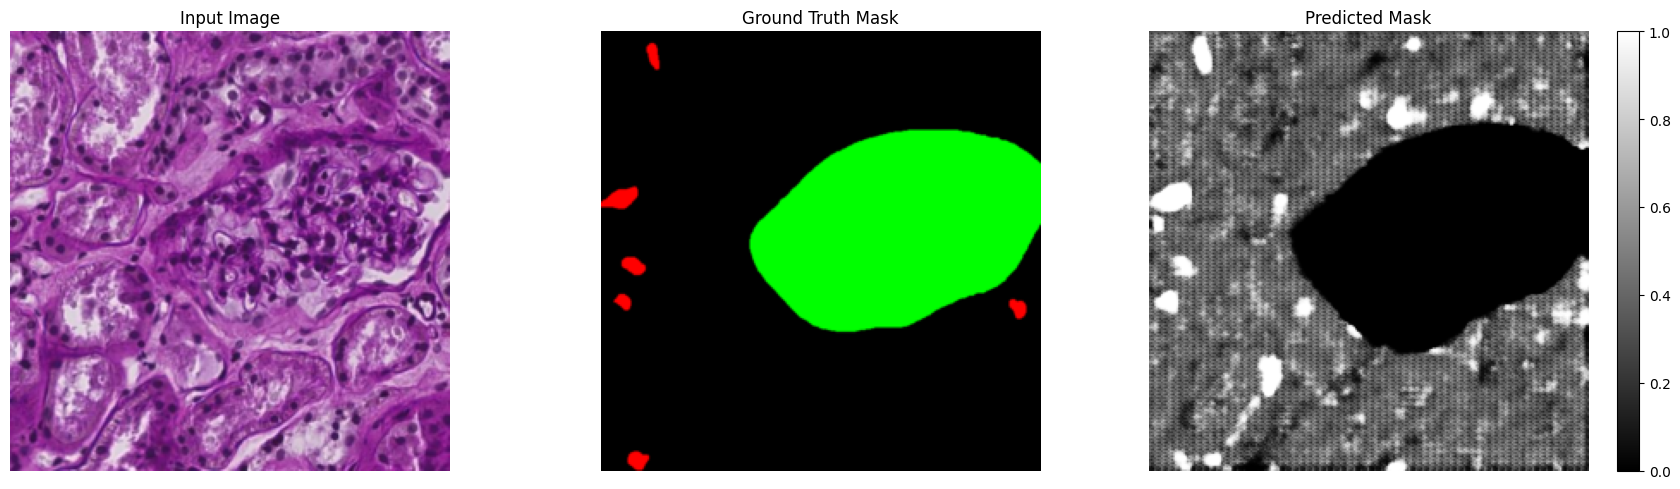

In [72]:
index = 25
image, mask = test_dataset[index]
image = image.to(device)
mask = mask.to(device)

model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    predicted_mask = torch.softmax(output.data, dim=1).squeeze().cpu().permute(1, 2, 0)[:,:,0]
    #predicted_mask = torch.argmax(output.data, dim=1).squeeze().cpu()

# Normalize image values between 0 and 1
predicted_mask = (predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min())
print(predicted_mask.shape)

image = image.permute(1, 2, 0)
#mask returns blood vessel, glomerulus and unsure mask on seperate RGB channels. 
#This means e.g. blood vessel is always displayed red, glomerulus green, unsure blue
mask = mask.permute(1, 2, 0)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(image.cpu())
ax[0].set_title('Input Image')
ax[0].axis('off')
ground_truth = ax[1].imshow(mask.cpu(), cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')
pred = ax[2].imshow(predicted_mask.numpy(), cmap='gray')
ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Adding a color bar to the third subplot
#colorbar = fig.colorbar(ground_truth, ax=ax[1])
colorbar = fig.colorbar(pred, ax=ax[2])
plt.tight_layout()
plt.show()